In [ ]:
# 📦 Instalación automática de paquetes requeridos
# Correr esta celda si cambias de entorno, compu o al compartir tu notebook

!pip install --upgrade pip
!pip install \
    torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu \
    torch-geometric \
    matminer \
    pymatgen \
    pandas \
    matplotlib \
    scikit-learn \
    jupyterlab \
    ipykernel \
    numpy

In [29]:
# 📘 Notebook: 02_model.ipynb
# Construcción del dataset para GNN y entrenamiento de modelo

import torch
from torch_geometric.data import Data
import pandas as pd
from matminer.datasets import load_dataset
from pymatgen.analysis.graphs import StructureGraph
from pymatgen.analysis.local_env import MinimumDistanceNN
import numpy as np

# Cargar dataset
df = load_dataset("matbench_mp_e_form")
print(f"Total samples: {len(df)}")


# Tomar un subconjunto pequeño para pruebas rápidas
df_small = df.sample(10, random_state=42).reset_index(drop=True)
# Lista para almacenar objetos Data de PyTorch Geometric
data_list = []

for i, row in df_small.iterrows():
    print(f"Procesando muestra {i}...")

    try:
        structure = row['structure']
        energy = row['e_form']

        # Crear grafo con CrystalNN
        sg = StructureGraph.with_local_env_strategy(structure, MinimumDistanceNN())
        edges = sg.graph.edges()

        # Nodos: número atómico de cada átomo
        z = torch.tensor([site.specie.Z for site in structure.sites], dtype=torch.float)

        # Aristas: pares de nodos conectados
        edge_index = torch.tensor(list(edges), dtype=torch.long).t().contiguous()

        # Crear objeto Data para PyTorch Geometric
        data = Data(x=z.view(-1, 1), edge_index=edge_index, y=torch.tensor([energy], dtype=torch.float))
        data_list.append(data)

    except Exception as e:
        print(f"Error in sample {i}: {e}")
        continue

print(f"Total graphs created: {len(data_list)}")

# Guardar data_list para usarlo en el entrenamiento (opcional)
torch.save(data_list, "data/gnn_graphs.pt")



Total samples: 132752
Procesando muestra 0...
Procesando muestra 1...
Procesando muestra 2...
Procesando muestra 3...
Procesando muestra 4...
Procesando muestra 5...
Procesando muestra 6...
Procesando muestra 7...
Procesando muestra 8...
Procesando muestra 9...
Total graphs created: 10


In [ ]:
import os
import torch

file_path = "data/gnn_graphs.pt"

if os.path.exists(file_path):
    print("✅ ¡Archivo encontrado! ✅")
    data_list = torch.load(file_path)
    print(f"📦 Número de estructuras guardadas: {len(data_list)}")
else:
    print("❌ El archivo no fue encontrado. Verifica que la ruta y el guardado estén correctos.")



In [1]:
from matminer.datasets import load_dataset

# Cargar solo los primeros 2 registros
df = load_dataset("matbench_mp_e_form")[:2]  # <- MUY IMPORTANTE
print(df.head())



                                           structure    e_form
0  [[0. 0. 0.] Pt, [1.40802527 1.40802527 1.40802...  1.995384
1  [[0. 0. 0.] Cd, [-3.88999977 -3.88999977 -3.88...  2.103048


In [2]:
df_small = df.sample(2, random_state=42).reset_index(drop=True)
df_small.head()


,structure,e_form
0,"[[0. 0. 0.] Cd, [-3.88999977 -3.88999977 -3.88...",2.103048
1,"[[0. 0. 0.] Pt, [1.40802527 1.40802527 1.40802...",1.995384


In [3]:
from pymatgen.analysis.graphs import StructureGraph
from pymatgen.analysis.local_env import MinimumDistanceNN
from torch_geometric.data import Data
import torch

# Lista para guardar los objetos tipo Data
data_list = []

for i, row in df_small.iterrows():
    try:
        structure = row['structure']
        energy = row['e_form']

        # Grafo de la estructura con vecinos locales
        sg = StructureGraph.with_local_env_strategy(structure, MinimumDistanceNN())
        edges = sg.graph.edges()

        # Nodo = número atómico
        z = torch.tensor([site.specie.Z for site in structure.sites], dtype=torch.float)

        # Aristas: nodos conectados
        edge_index = torch.tensor(list(edges), dtype=torch.long).t().contiguous()

        # Objeto tipo Data
        data = Data(x=z.view(-1, 1), edge_index=edge_index, y=torch.tensor([energy], dtype=torch.float))
        data_list.append(data)

        print(f"✓ Grafo {i} procesado.")

    except Exception as e:
        print(f"⚠️ Error en el grafo {i}: {e}")
        continue


✓ Grafo 0 procesado.
✓ Grafo 1 procesado.


In [4]:
import os
import torch

# Ruta donde se guardará el archivo
file_path = "data/gnn_graphs.pt"

# Asegúrate de que la carpeta 'data/' exista
os.makedirs("data", exist_ok=True)

# Guardar el archivo
torch.save(data_list, file_path)
print("✅ Archivo guardado exitosamente.")

# Verificar
if os.path.exists(file_path):
    print(f"📁 Archivo encontrado: {file_path}")
    graphs = torch.load(file_path)
    print(f"📊 Número de grafos guardados: {len(graphs)}")
else:
    print("❌ No se encontró el archivo.")


✅ Archivo guardado exitosamente.
📁 Archivo encontrado: data/gnn_graphs.pt


UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL torch_geometric.data.data.DataEdgeAttr was not an allowed global by default. Please use `torch.serialization.add_safe_globals([torch_geometric.data.data.DataEdgeAttr])` or the `torch.serialization.safe_globals([torch_geometric.data.data.DataEdgeAttr])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

In [22]:
from torch_geometric.data import Data
import torch
import re

# Verificar versión de PyTorch
torch_version = torch.__version__
major_minor = tuple(map(int, re.match(r"(\d+)\.(\d+)", torch_version).groups()))
print(f"📦 PyTorch versión detectada: {torch_version}")

# Ruta al archivo .pt
file_path = "data/gnn_graphs.pt"

# Registrar el paquete si PyTorch >= 2.6
if major_minor >= (2, 6):
    try:
        torch.serialization.register_package(
            "torch_geometric.data.data",     # Nombre del paquete
            {"Data": Data},                  # Clases seguras
            lambda s: eval(s)                # ⚠️ Deserializador inseguro (usa solo si el archivo es confiable)
        )
        print("🔐 Registro de clase `Data` exitoso con `register_package`")
    except Exception as e:
        print(f"❌ Error al registrar clase `Data`: {e}")

# Cargar el archivo
try:
    graphs = torch.load(file_path, weights_only=False)
    print(f"📊 Número de grafos cargados: {len(graphs)}")
except Exception as e:
    print(f"❌ Error al cargar el archivo `.pt`: {e}")


📦 PyTorch versión detectada: 2.7.1+cpu
❌ Error al registrar clase `Data`: '<' not supported between instances of 'str' and 'int'
📊 Número de grafos cargados: 2


In [23]:
# Mostrar tipo de dato y cantidad de grafos
print(type(graphs))
print(f"Cantidad de grafos: {len(graphs)}")

# Ver el primer grafo
print(graphs[0])


<class 'list'>
Cantidad de grafos: 2
Data(x=[2, 1], edge_index=[2, 4], y=[1])


In [25]:
# Ver información básica del primer grafo
graph = graphs[0]
print(graph)


Data(x=[2, 1], edge_index=[2, 4], y=[1])


In [26]:
# Listar atributos disponibles
print(graph.keys())

# Ver el número de nodos y aristas
print(f"Nodos: {graph.num_nodes}")
print(f"Aristas: {graph.num_edges}")


['x', 'y', 'edge_index']
Nodos: 2
Aristas: 4


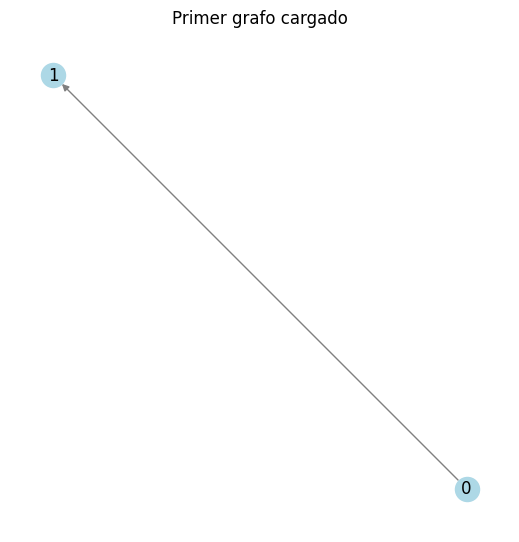

In [27]:
import networkx as nx
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt

# Convertir a objeto NetworkX
nx_graph = to_networkx(graph)

# Dibujar
plt.figure(figsize=(5, 5))
nx.draw(nx_graph, with_labels=True, node_color='lightblue', edge_color='gray')
plt.title("Primer grafo cargado")
plt.show()


In [28]:
import os
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx

# Crear carpeta si no existe
os.makedirs("images", exist_ok=True)

# Cuántos grafos quieres visualizar (puedes cambiarlo)
num_to_plot = 3

for i in range(min(num_to_plot, len(graphs))):
    graph = graphs[i]
    G = to_networkx(graph)

    plt.figure(figsize=(5, 5))
    nx.draw(G, 
            with_labels=True,
            node_color='skyblue',
            edge_color='gray',
            node_size=500,
            font_size=10)
    
    plt.title(f"Grafo {i}")
    plt.tight_layout()
    plt.savefig(f"images/graph_{i}.png")
    plt.close()

print(f"✅ Imágenes guardadas en la carpeta 'images/'")


C:\Users\ingna\AppData\Local\Temp\ipykernel_1344\81861731.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


✅ Imágenes guardadas en la carpeta 'images/'
